<a href="https://colab.research.google.com/github/disavida/covid19_pneumonia_classification/blob/main/covid_pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting drive directory into google colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Covid-19 and Pneumonia Classification with Deep Learning

## Project description
This project is meant to support doctors with diagnosing illnesses that affect patients’ lungs. The data was obtained from [X-ray lung scans](https://www.kaggle.com/pranavraikokte/covid19-image-dataset) with examples of patients who had either pneumonia, Covid-19, or no illness. Using the Keras module, I created a classification model that outputs a diagnosis based on a patient’s X-ray scan. Hopefully this project could help doctors with the challenge of deciphering X-ray scans by creating learning models that are as effective and interpretable as possible.

In [2]:
!pip install -U efficientnet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import efficientnet.keras as efn
from keras.models import load_model



from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

!ls

     |████████████████████████████████| 51kB 5.0MB/s 
drive  sample_data


 I used an `ImageGenerator` object in order to load the image data and get it ready for the journey through the neural network.

When creating the object, the data was normalized to get the image data ready for your neural network and get the best results.

Found 4137 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found GPU at: /device:GPU:0


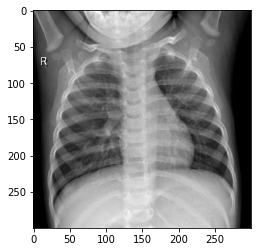

In [3]:
batch_size = 20
target_size = 300


train_generator = ImageDataGenerator(rescale=1.0/255)

test_generator = ImageDataGenerator(rescale=1.0/255)

train_iterator = train_generator.flow_from_directory('/content/drive/MyDrive/COVID_PNEUMONIA_CLASSIFICATION/train', 
                                                     target_size = (target_size, target_size), 
                                                     color_mode = 'rgb', 
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size)

test_iterator = test_generator.flow_from_directory('/content/drive/MyDrive/COVID_PNEUMONIA_CLASSIFICATION/test', 
                                                   target_size = (target_size, target_size), 
                                                   color_mode = 'rgb', 
                                                   class_mode = 'categorical',  
                                                   batch_size=batch_size)

%tensorflow_version 2.x
import tensorflow as tf
gpu_device = tf.test.gpu_device_name()
if gpu_device != '/device:GPU:0':
  print('GPU device not found')
  pass
else:
  print('Found GPU at: {}'.format(gpu_device))

#Get and show an image from train_iterator
batch = next(train_iterator)
img = batch[0][0]
plt.imshow(img)
plt.show()

Now that our image data is loaded and ready for analysis, let's create a classification neural network model to perform on the medical data.

When starting the neural network, there some things to considerate:

* The shape of your input
* The shape of your output
* Using any activation functions for your output
* The gradient descent optimizer
* Learning rate
* Loss functions and metrics
* Flattening the image data before the output layer

Now, it is time to use `model.fit(...)` to train the model.

* The first argument should be the `train_iterator`.
* `steps_per_epoch` is defined as the length of the training data, divided by the batch size.
* Set `validation_data` to be the `test_iterator`.
* Set `validation_steps` to be the length of the validation data, divided by the batch size.

In [6]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[target_size, target_size, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

model = create_model()
model.summary()

#Save checkpoints
checkpoint_filepath = '/content/drive/MyDrive/COVID_PNEUMONIA_CLASSIFICATION/checkpoint'

#Callbacks
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', mode = 'max', restore_best_weights = True)

#Fit model
history = model.fit(train_iterator, 
                  steps_per_epoch=4137/batch_size, 
                  epochs=2, 
                  validation_data=test_iterator,
                  callbacks=[early_stopping_callback])

#Save model
model.save('/content/drive/MyDrive/COVID_PNEUMONIA_CLASSIFICATION/tmp/my_model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/2
206/206 [==============================] - 167s 790ms/step - loss: 0.2663 - accuracy: 0.8949 - val_loss: 1.3132 - val_accuracy: 0.7984
Epoch 2/2
206/206 [==============================] - 162s 784ms/step - loss: 0.0933 - accuracy: 0.9682 - val_loss: 0.1463 - val_accuracy: 0.9506


In [7]:
model = load_model('/content/drive/MyDrive/COVID_PNEUMONIA_CLASSIFICATION/tmp/my_model.h5')

predict_generator = ImageDataGenerator(rescale = 1./255)
predict_iterator = predict_generator.flow_from_directory('/content/drive/MyDrive/COVID_PNEUMONIA_CLASSIFICATION/predict', shuffle = False)

score = model.evaluate(predict_iterator)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Found 78 images belonging to 3 classes.
3/3 [==============================] - 21s 9s/step - loss: 0.2005 - accuracy: 0.9231
Test loss: 0.20049792528152466
Test accuracy: 0.9230769276618958


## Metrics of the project


In [8]:
y_predicted = tf.math.argmax(model.predict(predict_iterator), axis = 1)
# print(y_predicted)

y_true = predict_iterator.classes
# print(y_true)

print(classification_report(y_true, y_predicted, target_names =['COVID','NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        26
      NORMAL       0.86      0.92      0.89        26
   PNEUMONIA       0.92      0.85      0.88        26

    accuracy                           0.92        78
   macro avg       0.92      0.92      0.92        78
weighted avg       0.92      0.92      0.92        78



[Text(0, 0.5, 'Covid'), Text(0, 1.5, 'Normal'), Text(0, 2.5, 'Pneumonia')]

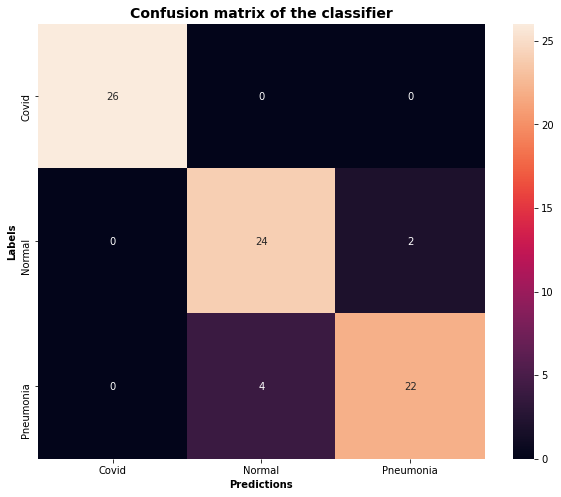

In [9]:
#Labels
thisdict = ['Covid', 'Normal', 'Pneumonia']

#Create the confusion matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_predicted)

#Create the figure and get the graphic current axis
plt.figure(figsize=(10, 8))
ax = plt.gca()

#Set title
plt.title('Confusion matrix of the classifier', fontsize=14, weight = 'bold')

plt.xlabel('predictions')
#Create the heatmap
sns.heatmap(conf_matrix, 
            annot=True, fmt='g')

#Set axis labels
plt.ylabel('Labels', weight = 'bold')
plt.xlabel('Predictions', weight = 'bold')


#Set the tick labels according to the category of the galaxy
ax.set_xticklabels(thisdict)
ax.set_yticklabels(thisdict)

Metrics: ['loss', 'accuracy', 'val_loss', 'val_accuracy']
 


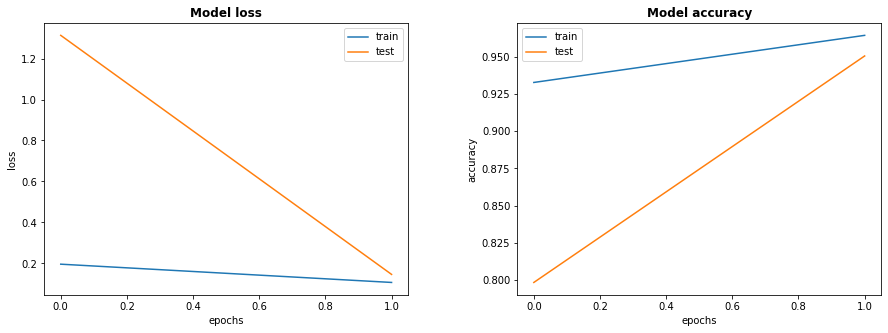

In [10]:
#Obtain the history metric names of the model
keys = list(history.history.keys())

print('Metrics: ' + str(keys))
print(' ')

#Make 2 subplots
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))

#First plot      
ax0.plot(history.history[keys[0]])
ax0.plot(history.history[keys[2]])
      
ax0.set_title('Model ' +  str(keys[0]), weight = 'bold')
ax0.legend(['train', 'test'])
ax0.set_ylabel(keys[0])
ax0.set_xlabel('epochs')

#Second plot
ax1.plot(history.history[keys[1]])
ax1.plot(history.history[keys[3]])
      
ax1.set_title('Model ' +  str(keys[1]), weight = 'bold')
ax1.legend(['train', 'test'])
ax1.set_ylabel(keys[1])
ax1.set_xlabel('epochs')
      
#Plot adjustment    
plt.subplots_adjust(wspace=0.3)

#Show plot
plt.show()